In [1]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=True
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1


In [2]:
# fps
dfp = '/home/ngr4/project/scnd/data/'
pfp = '/home/ngr4/project/scnd/results/'
pdfp = '/home/ngr4/project/scnd/data/processed/'
sc.settings.figdir = pfp
    
if True :
    # load human
    start = time.time()
    backed=None # None if not
    fname='hum_MT_bbknn.h5ad' # for full, can maybe get away with ~300G
    %memit hdata = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    
if True :
    # load data objects
    start = time.time()
    backed=None # None if not
    fname='mouse_MT_bbknn.h5ad' # for full, can maybe get away with ~300G
    %memit mdata = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 20560.72 MiB, increment: 20356.60 MiB
loaded @200324.11:23:25
took 131.66-s to load data
peak memory: 159628.75 MiB, increment: 149210.05 MiB
loaded @200324.11:26:03
took 158.82-s to load data


In [14]:
# color map in order 
cmap_ctype_hum={'Granule cell': '#FAC18A',
                'GABAergic interneuron 1': '#F9EBAE',
                'GABAergic interneuron 2': '#88BB92',
                'Astrocyte': '#F9AEAE',
                'Bergmann glia': '#AEB7F9',
                'Oligodendrocyte progenitor cell': '#F1815F',
                'Oligodendrocyte': '#75A3B7',
                'Microglia': '#AC5861',
                'Pericyte': '#2D284B'}
hdata.uns['ctype_colors']=np.array(list(cmap_ctype_hum.values()),dtype=object)
hdata.obs['ctype'].cat.reorder_categories(new_categories=list(cmap_ctype_hum.keys()),
                                         inplace=True,ordered=True)

cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE'}
mdata.uns['ctype_colors']=np.array(list(cmap_ctype.values()),dtype=object)
mdata.obs['ctype'].cat.reorder_categories(new_categories=list(cmap_ctype.keys()),
                                         inplace=True,ordered=True)

In [31]:
# markers 
prevmarkers = {'Granule cell':['Gabra6'],
                'Excitatory neuron':['Slc17a6'],
                'Purkinje cell':['Atp2a3','Calb1','Ca8','Ppp1r17','Slc1a6'],
                'Stellate/Basket/Golgi':['Megf10','Ntn1'],
                'Astrocyte':['Aldh1l1','Aqp4','Slc1a3'],
                'Bergmann glia':['Gdf10','Hopx','Timp4'],
                'OL lineage':['Olig1','Olig2'],
                'OPC':['C1ql1','Pdgfra','Ninj2'],
                'OL':['Hapln2','Mag','Mog','Opalin'],
                'Microglia':['C1qb','Cx3cr1','Dock2','P2ry12'],
                'Pericytes':['Flt1','Pdgfrb','Rgs5'],
                'Vascular':['Dcn','Lum'],
                'Choroid plexus':['Folr1','Ttr']} 

mousemarkers = {'Granule cell':['Gabra6','Slc17a7'],
                'Unipolar brush cell':['Slc17a6','Eomes'],
                'Purkinje cell':['Atp2a3','Calb1','Car8','Ppp1r17','Slc1a6'],
                'Inhibitory interneuron':['Gad1','Gad2','Ntn1','Megf10'],
                'Astrocyte':['Aldh1l1','Aqp4'],
                'Bergmann glia':['Gdf10','Hopx'],
                'OPC':['Olig1','Olig2','Pdgfra'],
                'OL':['Hapln2','Mag','Mog','Opalin'],
                'Microglia':['C1qb','Cx3cr1','Dock2','P2ry12'],
                'Pericytes':['Flt1','Rgs5'],
                'Endothelial cell':['Dcn','Lum','Kdr']}

# Car8 -> Ca8
hsmarkers = {'Granule cell':['Gabra6','Slc17a7'],
                'Inhibitory interneuron':['Gad1','Gad2','Ntn1','Megf10'],
                'Astrocyte':['Aldh1l1','Aqp4'],
                'Bergmann glia':['Gdf10','Hopx'],
                'OPC':['Olig1','Olig2','Pdgfra'],
                'OL':['Hapln2','Mag','Mog','Opalin'],
                'Microglia':['C1qb','Cx3cr1','Dock2','P2ry12'],
                'Pericytes':['Flt1','Rgs5']}

humanmarkers = {}
for k,v in hsmarkers.items() : 
    newlist = []
    for g in v :
        newlist.append(g.upper())
    humanmarkers[k] = newlist

    
leon_mouse = {'GC check':['Cbln3','Cbln1','Grin2c','Slc17a7']}
leon_hum = {}
for k,v in leon_mouse.items() : 
    newlist = []
    for g in v :
        newlist.append(g.upper())
    leon_hum[k] = newlist

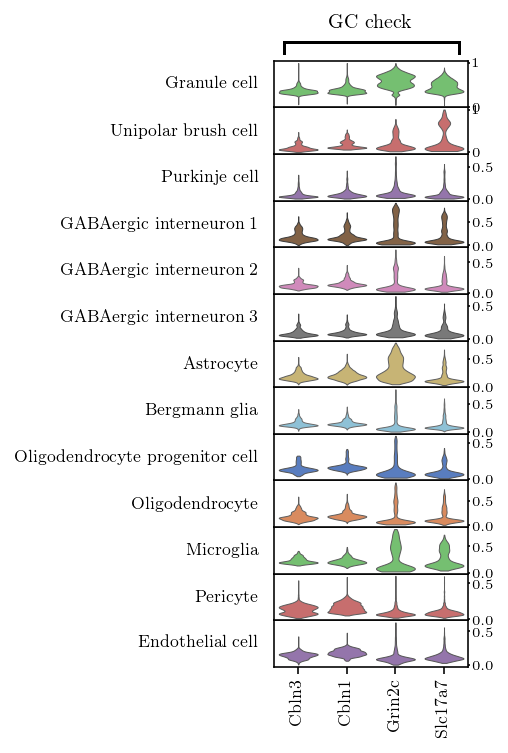

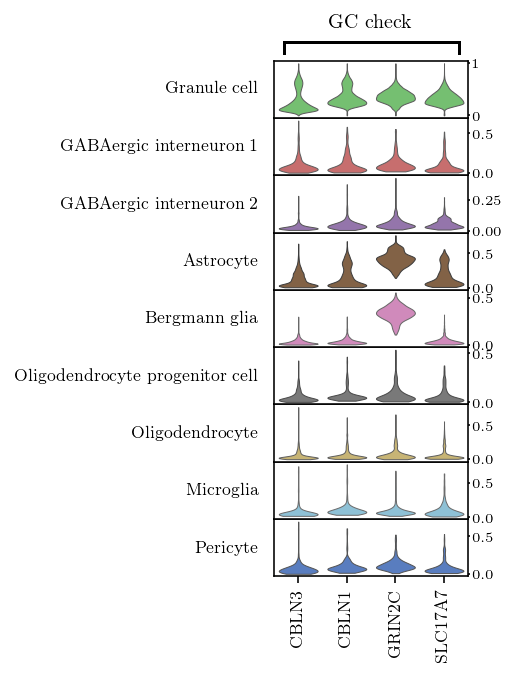

In [30]:
# marker check 
## mouse plot
sc.pl.stacked_violin(mdata,leon_mouse,
                     groupby='ctype',
                     use_raw=False,
                     layer='imputed_bbknn',
                     standard_scale='var',
                     var_group_rotation=0,
                     save='_mouse_inquiry.pdf')

## human plot
sc.pl.stacked_violin(hdata,leon_hum,
                     groupby='ctype',
                     use_raw=False,
                     layer='imputed_bbknn',
                     standard_scale='var',
                     var_group_rotation=0,
                     save='_hum_inquiry.pdf')

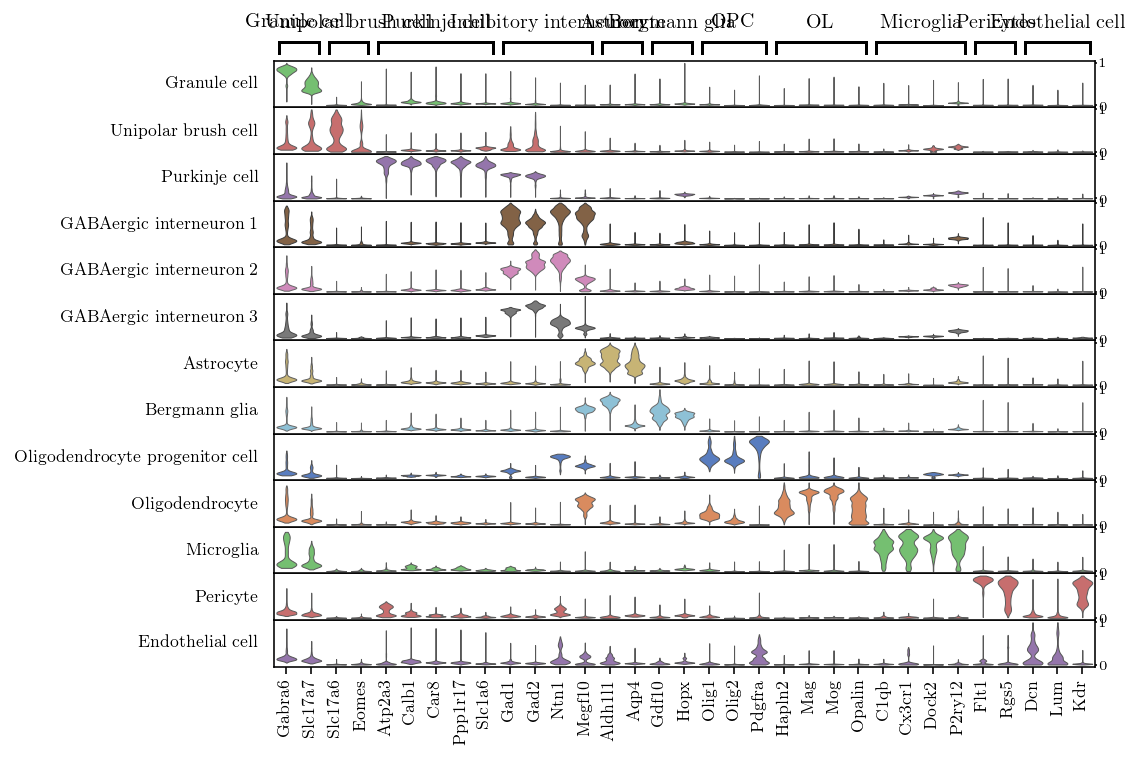

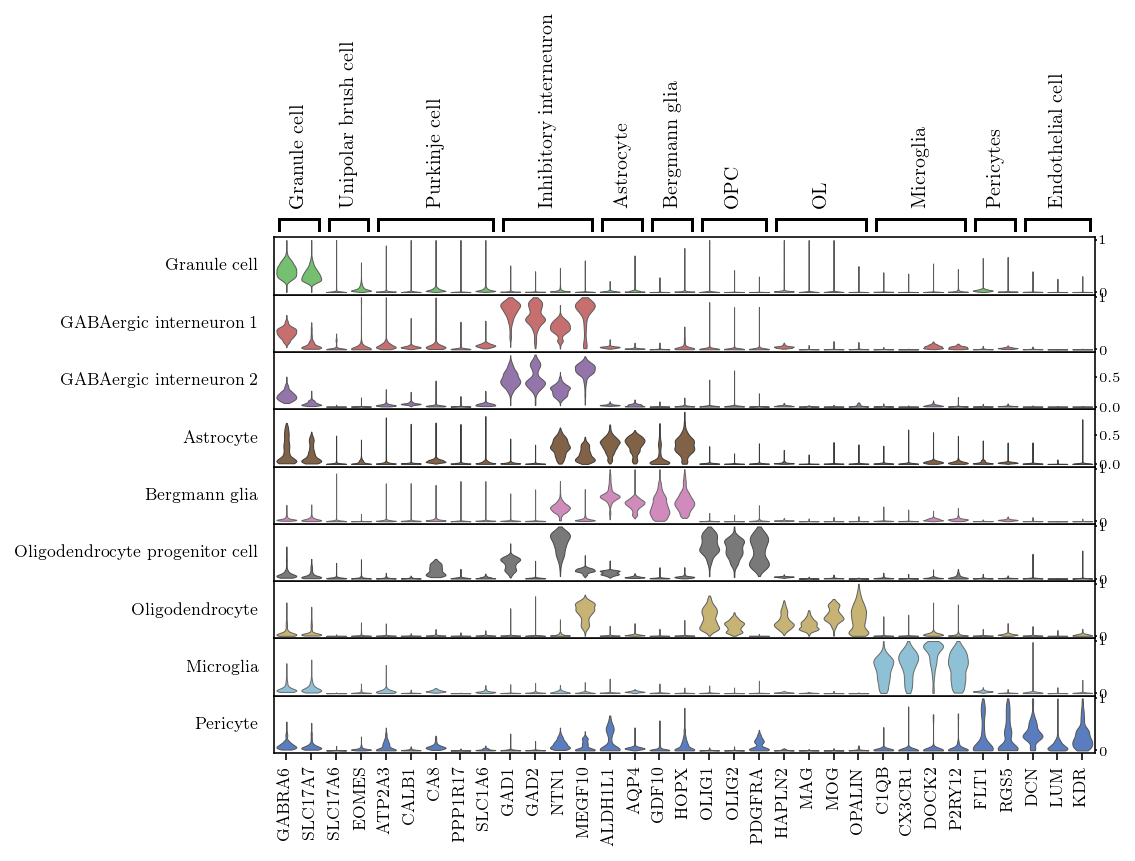

In [32]:
# final marker list
## mouse plot
sc.pl.stacked_violin(mdata,mousemarkers,
                     groupby='ctype',
                     use_raw=False,
                     layer='imputed_bbknn',
                     standard_scale='var',
                     var_group_rotation=0,
                     save='_mouse_ctype.pdf')

## human plot
sc.pl.stacked_violin(hdata,humanmarkers,
                     groupby='ctype',
                     use_raw=False,
                     layer='imputed_bbknn',
                     standard_scale='var',
                     var_group_rotation=90,
                     save='_hum_ctype.pdf')